# 07 - Beyond Confounders

## Good Controls

5장에서는 회귀 모델에 통제변수를 추가하는 것이 어떻게 인과추론에 도움을 주는지 보았습니다. 통제변수가 `confounder`라면 반드시 모델에 추가해야 합니다. 부주의한 사람의 자연스러운 반응은 측정할 수 있는 모든 변수를 모델에 넣는 것입니다. 최근 빅데이터는 1000개 이상의 변수를 포함하기도 합니다. 너무 많은 변수는 불필요하며 인과관계를 파악하는데 방해가 됩니다. 이제 `confounder`(교란변수)보다는 `control`(통제변수)를 공부해보겠습니다. 먼저 좋은 통제변수를 보고 다음으로 해로운 통제변수를 알아보겠습니다.

당신은 핀테크 데이터 수집 팀의 데이터 과학자입니다. 당신의 일은 연체된 고객에게 상환을 요청하는 메일의 영향도를 파악하는 것입니다. `response variable`(응답변수)는 상환 금액입니다.

당신은 고객 중 무작위 실험 대상 5000명을 선택합니다. 모든 고객에 대해 동전을 던져 앞면이 나오면 메일을 보냅니다. 나머지 절반은 대조군으로 남겨둡니다. 무작위 실험으로 메일이 얼마나 많은 돈을 갚게 하는지 확인할 수 있습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


무작위 데이터이므로 단순하게 평균값 차이로 `ATE`(평균 처치 효과)를 추정할 수 있습니다. 무작위화로 `treatment` 외에는 결과에 영향을 주는 요인이 없습니다. 즉, `potential outcome`은 `treatment`와 독립입니다: $(Y_0, Y_1)\perp T$.

$
ATE = E[Y|T=1] - E[Y|T=0]
$

똑똑한 당신은 추정치와 신뢰구간을 얻기 위해 선형 회귀 분석을 사용합니다.

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


이상하게도 `ATE`는 -0.62입니다. 어떻게 메일을 보내는 것이 악영향을 줄까요? `p-value`가 너무 높아 결과를 믿을 순 없습니다. 문제를 해결해야 합니다. 테스트에 더 많은 데이터가 필요하다고 말해볼까요? 아직은 아닙니다.

데이터에 다른 `feature`가 있습니다. `credit_limit`은 연체 전 고객의 신용한도입니다. `risk_score`는 메일 발송 전 고객의 예상 위험도입니다. 신용한도와 위험도는 상환의 좋은 예측변수일 겁니다. 추가 변수가 어떻게 유용해지는지 살펴봅시다.

먼저 `treatment`가 있어도 통계적 유의성을 찾지 못하는 이유를 알아보겠습니다. 지금처럼 `treatment`가 `outcome`에 영향을 주지 않을 수도 있습니다. 사실 상환에 필요한 요소는 통제할 수 없습니다. 고객은 스스로 새로운 직업을 찾거나 돈을 관리하여 빚을 갚아야 합니다. 통계적 용어로 표현하면, **산환금액의 변동을 이메일 보다 훨씬 더 많이 설명할 수 있는 다른 인자들이 존재한다**고 말할 수 있습니다.

시각적으로 이해하기 위해 `treatment`(`Email`)과 상환금액(`Payments`)를 그래프로 그려보겠습니다. 빨간색 선은 선형 회귀 결과입니다. (시각화를 위해 `treatment`에 약간의 노이즈를 추가합니다.)

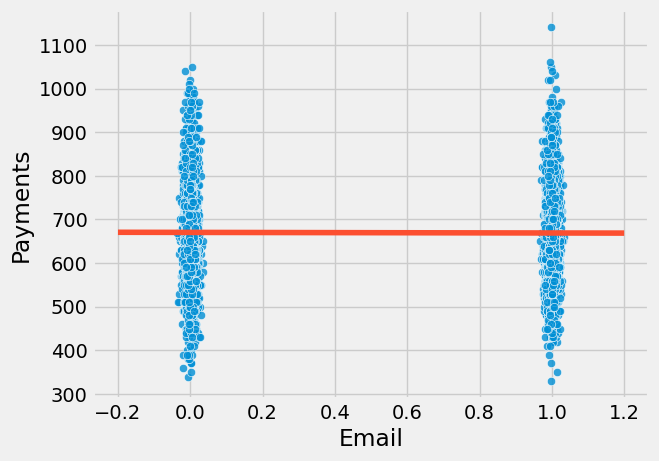

In [4]:
sns.scatterplot(x="email", y="payments", 
                alpha=0.8,
                data=data.assign(email=data["email"] + np.random.normal(0, 0.01, size=len(data["email"]))))
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");

개별 처치 그룹에서 상환액이 다양합니다. 두 그룹 모두 400 ~ 1000 사이입니다. 만약 이메일의 영향이 5.00 ~ 10.00 수준이라면 더 큰 분산 안에서 영향을 찾을 수 없겠습니다.

다행히도 추가 통제변수를 사용한 회귀 분석으로 분산을 줄일 수 있습니다. **한 변수가 결과에 대한 좋은 예측 변수라면 많은 분산을 설명합니다.** 신용한도와 위험도가 상환금액의 좋은 예측 변수라면 이메일의 영향을 더 쉽게 찾을 수 있도록 해줍니다. 회귀의 작동방식을 생각하면 직관적으로 이해할 수 있습니다. 회귀 변수를 추가하면 `treatment`를 바꾸는 동안 통제변수의 수준을 일정하게 유지할 수 있습니다. 유사한 수준에서 신용한도와 위험도를 유지한다면 상환금액에 대한 분산은 더 작아야 합니다. 또는, 신용한도와 위험도가 상환금액을 매우 잘 예측한다면 비슷한 고객은 상환금액도 비슷해야 하므로 분산이 작습니다.

<figure>
    <img src="data/img/beyond-conf/y-pred.png">
    <figcaption>변수가 편향을 줄이진 않지만 통계적 유의성을 좋게 할 때</figcaption>
</figure>

설명을 위해 회귀 분석을 두 단계로 나누겠습니다. 먼저 `treatment` email과 `outcome` payments를 통제변수인 credit limit, risk score로 추정합니다. `treatment`와 `outcome`의 잔차를 계산하여 잔차에 대해 회귀 분석을 수행합니다. (설명을 위한 과정으로 실제로는 이렇게 복잡하지 않습니다.)

In [5]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

`residuals`를 사용하면 `outcome`의 분산이 감소합니다. 신용한도 및 위험도로 상관금액을 예측하는 모델을 만들고 잔차를 계산함으로써 원래보다 변동이 작은 새로운 종속변수를 만들고 있습니다. 두 번째 모델은 유효한 표준 오차를 가진 `ATE`를 계산합니다.

또한, `treatment`를 예측하는 모델은 `treatment`의 분산을 낮추지 않음을 확인할 수 있습니다. 설계상 이메일 발송이 무작위이므로 예측이 불가능하기 때문입니다.

In [6]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.612416
Payments Residual Variance 5652.453558466208
Email Variance 0.24991536
Email Residual Variance 0.24918421069820032


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.92e-14,1.063,2.75e-14,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


이제 합리적인 `ATE`를 얻었습니다. 새로운 추정값은 이메일을 받은 고객이 대조군보다 평균적으로 4.4만큼 더 상환할 것을 의미합니다. 이 값은 $0$과 통계적으로 다릅니다. 각 `treatment` 그룹 내에서 분산이 얼마나 낮아지는지 시각화해보겠습니다.

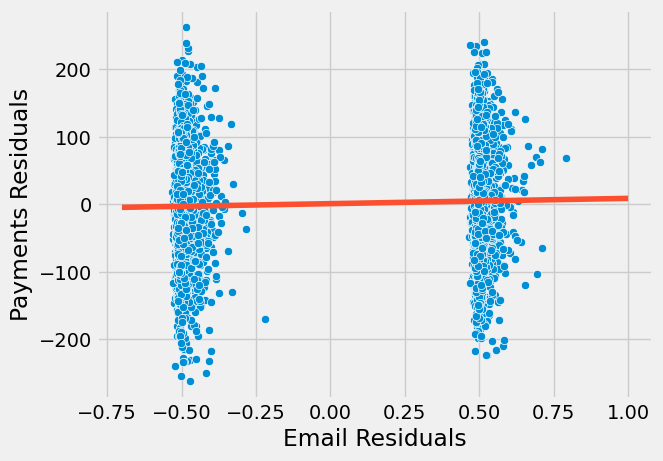

In [7]:
sns.scatterplot(x="res_email", y="res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

지금까지 교육적인 목적으로 모델을 두 개 만들었습니다. 실제로는 통제변수를 `treatment`와 함께 회귀 모형에 넣으면 됩니다.

In [8]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


결과를 잘 예측하는 통제변수는 교란변수가 아니더라도 모델에 추가하는 것이 좋습니다. 이러한 통제변수는 `treatment effect` 추정치의 분산을 도움을 줍니다. 인과 그래프를 그려보겠습니다.

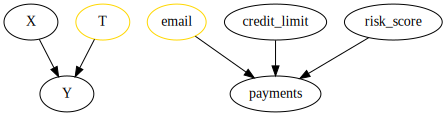

In [9]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## Mostly Harmful Controls

두 번째 예시로 2개 병원의 약물 실험을 살펴봅시다. 병원들은 신약에 대해 무작위 실험을 진행합니다. `outcome`은 입원 일수입니다. 치료가 효과적이면 입원 기간을 줄일 수 있습니다. A 병원은 환자 중 90%에 약을 주고 10%는 가짜 약을 줍니다. B 병원은 환자 중 10%에 약을 주고 90%는 가짜 약을 줍니다. 또한, A 병원은 B 병원보다 위중한 환자를 받습니다.

In [10]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


무작위 데이터이므로 단순히 `outcome`에 대해 회귀 분석을 진행합니다.

In [11]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


이상한 결과입니다. 어떻게 치료가 입원 기간을 늘릴까요? 원인은 두 가지 다른 실험을 하고 있기 때문입니다. 중증도(severity)는 긴 입원 기간과 긍정적인 상관관계가 있으며 중증도가 큰 질병은 더 많은 약을 받는 경향이 있어 투약 또한 긴 입원 기간과 긍정적인 상관관계가 있습니다. 두 병원을 함께 보면 $E[Y_0|T=0]<E[Y_0|T=1]$ 입니다. 즉, 중증도가 낮은 경우 병원에서 `untreated`로 분류하는 경향이 있으므로 `untreated`의 `potential outcome`이 평균적으로 작습니다. 중증도는 환자가 병원을 결정하는 요인으로 약을 받을 확률에 영향을 주는 `confounder`로 작용합니다.

문제를 해결하는 방법은 두 가지 있습니다. 첫 번째 방법은 각 병원의 ATE를 개별적으로 얻는 것입니다.

In [12]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [13]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


합리적인 `ATE`를 얻었습니다. 약을 처방하는 것이 입원 기간을 줄이는 것처럼 보입니다. 하지만 데이터를 분리했기 때문에 데이터 수가 부족해집니다. 따라서 통계적으로 유의미한 결과를 얻을 수 없습니다.

두 번째 방법은 모델에 중증도를 포함하여 통제하는 것입니다.

In [14]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


다음 질문은 병원도 모델에 포함해야 하는가 하는 것입니다. 병원도 `treatment`를 유발하는 요인이잖아요? 글쎄요... 맞는 말이지만 중증도를 통제하면 병원 자체는 입원 기간과 관련이 없습니다. 또한, 변수는 `treatment`와 `outcome` 모두에 영향을 줘야 합니다. 병원은 `treatment`에만 영향을 줍니다.

그래도 병원을 통제하면 분산이 줄어들겠죠? 음... 그렇지 않습니다. 통제변수가 분산을 낮추려면 `treatment`가 아니라 `outcome`에 대한 좋은 예측 변수여야 합니다.

그래도, 통제하면 어떨까요? 나빠질 리가 없을 것 같은데요?

In [15]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


신기하게도 더 나빠졌습니다.

<figure>
    <img src="data/img/beyond-conf/shocked.png">
    <figcaption>모든 변수를 모델에 넣지 마세요 / 다 넣음 / P-value: 0.9999 / ???</figcaption>
</figure>

중증도와 병원을 통제변수로 추가하면 `ATE` 추정치의 분산이 증가합니다. 어떻게 된 일일까요? 정답은 회귀 계수의 표준 오차 공식에 있습니다.

$
\hat{\sigma}^2 = \dfrac{1}{n-2} \sum( y_i - \hat{y}_i )^2
$

$
\text{Var}(\hat{\beta}_2) = \dfrac{\sigma^2}{\sum(x_i - \bar{x})^2}
$

공식에서 표준 오차는 $X$의 분산에 반비례합니다. $X$가 크게 변하지 않으면 결과에 미치는 영향을 추정하기 어렵다는 의미입니다. 직관적으로 이해해봅시다. 극단적으로 10000명을 대상으로 실험하지만 그 중 1명에게만 진짜 약을 줍니다. 이는 `ATE`를 계산하는 것을 어렵게 만들고 한 사람을 다른 모든 사람과 비교해야 합니다. 즉, 처치의 영향을 쉽게 알기 위해서는 처치에 큰 분산성이 필요합니다.

병원은 `treatment`에 좋은 예측 변수이므로 모델에 병원을 포함하면 추정치의 오차를 증가시킵니다. `treatment`를 예측함으로써 분산이 작아지기 때문입니다. 자세한 설명을 위해 회귀를 두 단계로 나눠보겠습니다.

In [16]:
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.828e-14,0.827,4.63e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


In [17]:
print("Treatment Variance", np.var(hospital["treatment"]))
print("Treatment Residual Variance", np.var(residuals["res_treatment"]))

Treatment Variance 0.234375
Treatment Residual Variance 0.05752909187211906


앞의 SE 공식이 참인지 확인해 봅시다.

In [18]:
sigma_hat = sum(model_treatment.resid**2)/(len(model_treatment.resid)-2)
var = sigma_hat/sum((residuals["res_treatment"] - residuals["res_treatment"].mean())**2)
print("SE of the Coeficient:", np.sqrt(var))

SE of the Coeficient: 3.4469737674869023


따라서 모델에는 중증도와 같이 `treatment`와 `outcome`과 관련 있는 통제변수를 추가해야 합니다. 추정치 분산을 낮추기 위해서는 `confounder`가 아니더라도 `outcome` 예측에 도움이 되는 변수를 추가해야 합니다. 하지만 `treatment` 예측에만 좋은 변수는 추가하면 **안됩니다.**

인과 그래프를 그려봅시다.

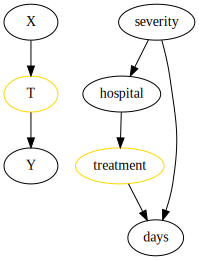

In [19]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

## Bad Controls - Selection Bias

처음의 무작위 이메일 발송 예제로 돌아갑니다. `credit_limit`, `risk_score` 외 남은 변수를 살펴보겠습니다. `open`은 고객의 이메일 개봉 여부에 대한 더미 변수입니다. `agreement(합의)`는 고객이 이메일을 받은 후 채권 추심 부서에 연락하여 부채를 협상했는지 여부를 알려주는 더미 변수입니다. 다음 중 어떤 모델이 더 적합할까요?

1. `treatment` + `credit_limit` + `risk_score`
2. `treatment` + `credit_limit` + `risk_score` + `opened` + `agreement`

In [20]:
email_1 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
email_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [21]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


모델 1은 이메일에 대해 통계적으로 유의한 결과를 찾지만, 모델 2는 그렇지 않습니다. 하지만 모델 2가 맞는 모델이고 이메일은 아무런 영향이 없을 수도 있습니다. 모델 2는 더 많은 변수를 제어하므로 더 강력해야 합니다. 그렇죠? 당신은 아마 모델 2가 맞지 않다고 (옳게) 생각할 수 있습니다. 자세히 알아봅시다.

우리는 `confounding`(교란변수)를 반드시 추가해야 함을 알고 있습니다. `confounding`은 `treatment`와 `outcome` 모두 영향을 주는 변수입니다. `outcome`을 잘 예측하는 통제변수를 추가하는 것도 좋습니다. 필수는 아니지만 있으면 좋습니다. 또한, `treatment`만 잘 예측하는 통제변수는 넣으면 안 됩니다. 될 수 있으면 피하는 것이 좋습니다. 그렇다면 `opened`과 `agreement`는 어떤 통제변수일까요? 어떠한 것도 아닙니다.

생각해보면 `opened`과 `agreement`는 이메일과 분명히 관련이 있습니다. 이메일을 받지 못한다면 이메일을 열 수 없고, 합의는 이메일을 보낸 후에 발생한 재협상만 고려하기 때문입니다. 하지만 **이메일의 원인이 아닙니다! 두 변수는 이메일의 결과입니다!**

저는 변수를 다룰 때 인과 그래프를 그리는 것을 좋아합니다.

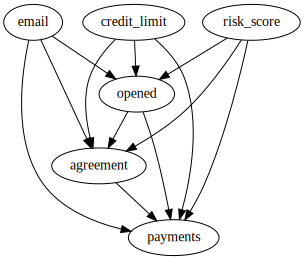

In [22]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

이메일 발송은 무작위로 어떠한 변수도 이메일에 영향을 주지 않습니다. 신용한도와 위험도는 상환에 영향을 주며 (적어도 믿을 만한 강력한 이유가 있습니다.) 이메일 또한 상환에 영향을 줍니다. `opened`는 상환의 원인일 수 있습니다. 상식적으로 이메일을 연 사람들은 협상과 상환에 적극적입니다. 마찬가지로 `opened`은 `agreement`의 원인입니다. 또한, 신용한도와 위험도가 높은 사람은 협상이 필요하므로 `opened`에 영향을 줄 수 있습니다. payments에 대해 아래와 같은 순서를 생각할 수 있습니다.

$
email -> opened -> agreement -> payment 
$

추가로 신용한도와 위험도에 따라 `agreement`(합의)하는 성향이 다르므로, 신용한도와 위험도는 `agreement`에 여부에 영향을 줍니니다. `email`과 `agreement`의 경우, 어떤 사람들은 이메일의 제목만 읽고 `agreement`를 할 가능성이 더 높다고 주장할 수 있습니다. 요점은 이메일을 열지 않아도 `agreement`를 유발할 수 있습니다.

인과 그래프로 알 수 있는 것은 이메일의 `opened`와 `agreement`가 모두 `email` 에서 `payments`까지 이어지는 인과적 경로에 있다는 사실입니다. 따라서, 회귀 모델로 이를 통제한다면 `opened`와 `agreement`를 고정한 채 이메일의 효과를 찾으려 할 것입니다. 하지만 `opened`와 `agreement`는 인과관계에 포함되어 있어 고정하고 싶지 않습니다. 대신, 이메일이 `agreement`를 높이므로 상환을 증가시킨다고 주장할 수 있습니다. 이러한 통제변수를 고정하면 이메일의 진짜 효과가 줄어들 수 있습니다.(진짜 효과의 일부를 제거할 수 있습니다.)

무작위 실험이기 때문에 $E[Y_0|T=0] = E[Y_0|T=1]$ 입니다. 하지만 `agreement`를 통제한다면 실험군과 대조군은 비교할 수 없습니다. 직관적으로 어떻게 다른지 추측할 수 있습니다.

$
E[Y_0|T=0, Agreement=0] > E[Y_0|T=1, Agreement=0]
$

$
E[Y_0|T=0, Agreement=1] > E[Y_0|T=1, Agreement=1]
$

첫 번째 방정식은 이메일을 받지 않고 동의도 하지 않은 사람들은 이메일을 받았으나 동의하지 않은 사람들보다 상환을 잘한다는 것을 의미합니다. 이메일이 상환에 치료가 긍정적인 영향을 준다면 **이메일을 받고도** 동의하지 않은 사람들은 이메일을 받지 않고 동의하지 않은 사람에 비해 상환을 덜하는 경향이 있을 수 있기 때문입니다. (일부러 상환을 안하는 경우) 두 번째 방정식은 이메일을 받지 않고 합의한 사람들은 이메일을 받고 합의한 사람들보다 상환을 잘한다는 의미입니다. (알아서 상환을 잘하는 경우)

헷갈릴 수 있지만, 반드시 이해해야 합니다. `opened`에 대해서도 비슷한 추론이 가능합니다. 직접 해보세요.

이러한 편향은 너무 널리 퍼져 있어서 따로 이름을 가지고 있습니다. `confounding`은 공통 원인에 대한 통제실패로 인한 편향이지만, **선택편향은 원인에서 결과 사이의 공통 효과 혹은 변수를 제어하는 편향입니다.** 경험적으로는 모델에 $Y$의 좋은 예측 변수와 교란 변수는 항상 포함해야 합니다. $T$에만 좋은 예측 변수나 `treatment`와 `outcome` 사이의 매개 변수는 항상 제외하세요.

![img](./data/img/beyond-conf/selection.png)

무작위화조차도 선택편향을 고칠 수 없습니다. 무작위 데이터라도 종종 잘못된 조언으로 도입되기도 합니다! 선택편향을 발견하고 피하는 것에 많은 연습이 필요합니다. 신박한 아이디어와 같이 따라오는 경우가 많아 밝혀내기가 훨씬 어렵습니다. 

아래는 제가 경험한 선택편향의 몇 가지 예입니다.
    
    1. 상환 전략이 상환에 미치는 영향을 추정할 때 전체 부채를 위한 더미 변수를 추가
    2. 학교 교육이 소득에 미치는 영향을 추정할 때 백인과 블루칼라 직업을 통제
    3. 금리가 대출기간에 미치는 영향을 추정할 때 전환을 통제
    4. 자녀가 혼외정사에 미치는 영향을 추정할 때 부부의 행복을 통제
    5. 상환 모델을 상환 발생 여부를 예측하는 이진 모델과 상환 금액을 예측하는 모델로 분리: E[Payments|Payments>0]*P(Payments>0)

사실 저도 선택편향의 함정에 여러 번 빠졌습니다. 특히 마지막 것은 매우 영리해 보이고 많은 데이터 과학자들의 허를 찌르는 것이기 때문에 추가 설명이 필요합니다. 가장 빈번한 것 중 하나로 **The Bad COP**이라는 이름을 가지고 있습니다.

### Bad COP

예측하려는 연속 변수에서 0인 데이터가 많다고 가정해 봅시다. 예를 들어 소비자 지출은 감마 분포와 유사하지만 0인 데이터가 많습니다.

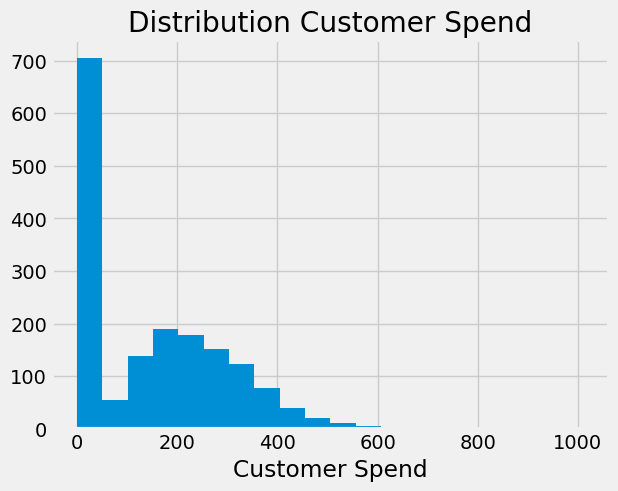

In [23]:
plt.hist(np.concatenate([
    np.random.gamma(5, 50, 1000), 
    np.zeros(700)
]), bins=20)
plt.xlabel("Customer Spend")
plt.title("Distribution Customer Spend");

데이터 과학자가 문제를 접할 때 떠올리는 첫 번째 아이디어는 모델을 두 단계로 나누는 것입니다. 첫 번째는 분류 모델로 $Y > 0$일 확률을 예측합니다. 분류 모델은 고객의 지출 여부를 결정합니다. 두 번째는 회귀 모델로 $Y$값을 예측합니다. 이는 긍정적 조건부 효과입니다. 예시에서는 고객이 소비하기로 한 후 소비하는 금액이 됩니다. `treatment` $T$가 치료가 지출에 미치는 영향을 추정한다면 다음과 같습니다.

$
E[Y|T] = E[Y|Y>0, T]P(Y>0|T)
$
 
참여 모델 $P(Y_i>0|T_i)$에는 문제가 없습니다. $T$가 무작위라면 `treatment`로 인한 지출 확률의 증가를 포착합니다. 또한, 모델의 분리에 이상이 없습니다. 수학적으로 총 확률의 법칙에 의해 참입니다.
 
문제는 COP 부분을 추정하는 데 있습니다. **이는 무작위라도 편향됩니다.** 직관적으로 `unit`들이 처치 받지 않았기 때문에 0이라 말하는 것은 이상하지 않습니다. `treatment`로 인해 0이 **아니게** 됩니다. 한편 일부 `unit`들은 절대 0이 아닙니다. `treatment`는 `outcome`을 증가시키지만 0으로 만들지 않습니다. 핵심은 이 두 가지 유형의 `unit`이 비교할 수 없다는 사실을 이해하는 것입니다. 0이 아닌 `unit`은 `treatment`가 없을 때 $Y_0>0$ 입니다. (실제로는 $Y_0=0$입니다.)
 
문제를 알고 0인 데이터를 제거하면 실험군과 대조군에서 모두 0값을 사용하지 않을 수 있습니다. 하지만 0을 제거하면 `treatment`가 0에서 0이 아닌 값으로 바뀌는 데이터를 제거하게 됩니다. 대조군에 0이 없고 $Y_0$이 큰 값만 포함되는 반면, 실험군에는 두 가지 유형이 모두 포함되기 더는 비교가 불가능합니다.

수학적으로 확인해 보겠습니다. 먼저 `treatment effect`를 분리합니다. 무작위 실험에서는 평균의 차이와 같습니다.
 
$$
\begin{align*} 
&E[Y|T=1] - E[Y|T=0]\\
&=E[Y|Y>0, T=1]P(Y>0|T=1) - E[Y|Y>0, T=0]P(Y>0|T=0)\\
&=\underbrace{\{P(Y>0|T=1) - P(Y>0|T=0)\}}_{Participation \ Effect} * E[Y|Y>0, T=1]\\
&+\underbrace{\{E[Y|Y>0, T=1] - E[Y|Y>0, T=0]\}}_{COP \ Effect} * P(Y>0|T=0)
\end{align*} 
$$
 
마지막 수식은 $E[Y_i|Y_i>0, T_i=1]P(Y_i>0|T_i=0)$을 더하고 빼서 얻을 수 있습니다. 평균의 차이는 두 부분으로 구성됩니다. 앞부분은 `outcome` $y$가 양수일 확률의 차이입니다. 고객이 지출에 참여할 확률의 증가를 측정하기 때문에 참여 효과라 불립니다. 뒷부분은 참여에 따라 결정되는 결과의 차이인 COP입니다. 지금까지는 아무 문제가 없으며 수학적으로 참입니다. 문제는 각 부분을 분리하려고 할 때 발생합니다.

COP 효과를 분석하면 분명해집니다.
 
$$
\begin{align*} 
E[Y|Y>0, T=1] - E[Y|Y>0, T=0]&=E[Y_{1}|Y_{1}>0]-E[Y_{0}|Y_{0}>0] \\
&=\underbrace{E[Y_{1} - Y_{0}|Y_{1}>0]}_{Causal \ Effect} + \underbrace{\{ E[Y_{0}|Y_{1}>0] - E[Y_{0}|Y_{0}>0] \}}_{Selection \ Bias}
\end{align*} 
$$
 
여기서 $E[Y_{i0}|Y_{i1}>0]$를 두 번째 등식이 나타납니다. COP 효과를 분해하면 먼저 참가자 하위 모집단에 대한 인과효과를 얻습니다. 무언가를 소비하기로 한 사람들의 인과적 영향이 될 것입니다. 또한, `treatment`에 의해 참여하기로 한 사람들($E[Y_{i0}|Y_{i1}>0]$)과 `treatment` 없이도 참여하는 사람들($E[Y_{i0}|Y_{i0}>0]$)에 의한 편항 항을 얻습니다. 편향은 부정적일 것입니다. `treatment`가 있음에도 참여하지 않은 사람은 `treatment`가 없을 때 참여하지 않은 사람보다 지출이 적을 것이기 때문입니다 ($E[Y_{i0}|Y_{i1}>0] < E[Y_{i0}|Y_{i0}>0]$).
 
![img](./data/img/beyond-conf/cop.png)
 
COP 편향은 직관적이지 않아 시각적으로 보는 것이 도움될 것입니다. 마케팅 캠페인이 제품에 얼마나 많은 돈을 쓰게 하는지 추정한다고 가정해 보겠습니다. 이 캠페인은 무작위로 진행되었으므로 `confounding`을 걱정할 필요는 없습니다. 고객을 두 부류로 나눕니다. 첫 번째 부류는 마케팅 캠페인을 봐야만 제품을 사는 고객(frugal) 입니다. 이들은 돈을 잘 쓰지 않아요. 두번 째 부류는 캠페인 없이도 제품을 사는 고객(rich) 입니다. 캠페인은 더 많이 팔게 해주지만 어쨌든 캠페인이 없어도 삽니다. 그림에서 `counterfactual`은 밝은색과 점선으로 표시합니다.
 
![img](./data/img/beyond-conf/cop-ex1.png)
 
무작위 캠페인이므로 `ATE`는 `treatment` 전후를 비교하면 됩니다. 그러나 COP 공식을 사용합니다. 모델을 참여 모델 $P(Y_i>0|T_i)$과 COP $E[Y_i|Y_i>0]$로 분리합니다. 이러면 돈을 쓰지 않은 모든 사람이 분석에서 제거됩니다.
 
![img](./data/img/beyond-conf/cop-ex2.png)
 
이제 실험군과 대조군은 더 이상 비교할 수 없습니다. `treatment`가 없는 경우 캠페인 없이도 지출할 부자 고객들로만 구성되어 있습니다. 편향은 부정적입니다. $E[Y_{i0}|Y_{i1}>0] - E[Y_{i0}|Y_{i0}>0]$ or $E[Y_{i0}|\text{Frugal and Rich}] - E[Y_{i0}|Rich]$. 부자 고객이 알뜰한 고객보다 더 많이 소비하기 때문입니다. 일단 참가 모집단만 필터링한다면 무작위 실험이라도 `ATE`에 대한 추정치는 편향됩니다. 당신 또한 동료가 COP를 피하도록 설득하기를 진심으로 바랍니다. 너무 많은 데이터 과학자들이 문제를 알지 못한 채 모델을 분리하고 있습니다.

선택편향을 마무리하기 전에 `treatment`와 `outcome` 사이에 있거나, `outcome`과 `treatment`에 영향을 받는 변수를 통제하면 안 된다는 사실을 염두에 둡시다.

인과 그래프에서 잘못된 통제는 아래와 같습니다.

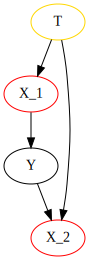

In [24]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g

## Key Ideas

7장에서는 `confounding`(교란변수)이 아닌 변수를 모델에 추가할 수 있는지 살펴보았습니다. `outcome` $y$의 좋은 예측 변수는 `treatment` $T$를 예측하지 않더라도 모델에 추가해야 합니다. $Y$를 예측하면 분산이 감소하고 인과 효과를 추정할 때 통계적으로 유의한 결과를 볼 가능성이 높아지기 때문입니다. `treatment`를 예측하지만 `outcome`을 예측할 수 없는 변수는 추가하면 안 됩니다. `treatment`의 분산을 줄여 인과 효과를 찾기 어렵게 만들기 때문입니다. 마지막으로, 선택편향을 알아봤습니다. 선택편향은 `treatment`에서 `outcome`에 이르는 인과 경로 내 변수나 `treatment`와 `outcome` 모두를 원인으로 하는 변수를 제어할 때 발생하는 편향입니다.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).